## AWnet test

In [1]:
from awnet import pwc_5x5_sigmoid_bilinear   # cm:import AWnet model
import torch
from torchvision import transforms, utils

AWnet = pwc_5x5_sigmoid_bilinear.pwc_residual().cuda()
AWnet.load_state_dict(torch.load('awnet/fs0_61_294481_0.00919393_dict.pkl'))
AWnet = AWnet.eval()

import warnings
warnings.filterwarnings("ignore")

def fuseTwoImages(I, J_hat):
    with torch.no_grad():
        fusedTensor,warp,mask = AWnet(J_hat,I)
    return fusedTensor, warp, mask

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def patchize(img):
    imgs = []
    H, W, C = img.shape
    ph = H//4
    pw = W//4
    img_empty = np.zeros((H+200, W+200, C))
    img_empty[100:-100, 100:-100] = img
    img = img_empty
    for i in range(4):
        for j in range(4):
            imgs.append(img[100+ph*i-18:100+ph*i+ph+18, 100+pw*j-32:100+pw*j+pw+32])
    imgs = np.stack(imgs)
    return imgs

def depatchize(imgs, pd_h = 18, pd_w = 32):
    ph = (imgs[0].shape[0]-2*pd_h)
    pw = (imgs[0].shape[1]-2*pd_w)
    img = np.zeros((ph*4, pw*4, 3))
    for i in range(4):
        for j in range(4):
            img[i*ph:i*ph+ph, j*pw:j*pw+pw] = imgs[i*4+j, pd_h:-pd_h, pd_w:-pd_w]
            
    return img

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(24,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
a = cv2.imread("dynamic_fs/68302_s550_03.jpg")[..., ::-1]/255.#[np.newaxis, :, :, ::-1].transpose(0, 3, 1, 2)/255.
b = cv2.imread("dynamic_fs/68302_s550_04.jpg")[..., ::-1]/255.#[np.newaxis, :, :, ::-1].transpose(0, 3, 1, 2)/255.
aa = patchize(a)

bb = patchize(b)
aa = torch.Tensor(aa.transpose(0, 3, 1, 2)).cuda()
bb = torch.Tensor(bb.transpose(0, 3, 1, 2)).cuda()
# imshow(utils.make_grid(a))
# imshow(utils.make_grid(b))
ccs = []
wws = []
for i in range(16):
    cc, ww, mask = fuseTwoImages(aa[i:i+1], bb[i:i+1])
    ccs.append(cc[0])
    wws.append(ww[0])
cc = torch.stack(ccs)
ww = torch.stack(wws)

c = depatchize(cc.cpu().detach().numpy().transpose(0, 2, 3, 1))
warp = depatchize(ww.cpu().detach().numpy().transpose(0, 2, 3, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


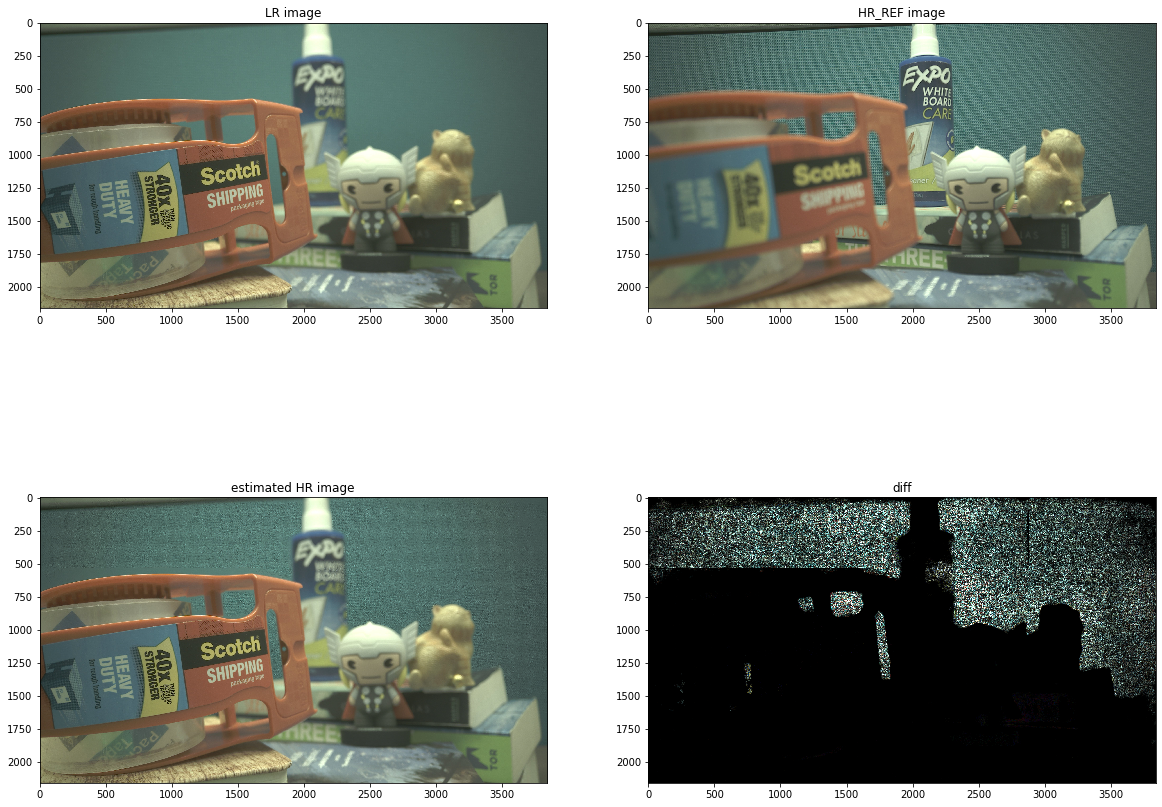

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(a)
ax[0][0].set_title('LR image')
ax[0][1].imshow(b)
ax[0][1].set_title('HR_REF image')
ax[1][0].imshow(c)
ax[1][0].set_title('estimated HR image')
ax[1][1].imshow(np.abs(c-a)*10)
ax[1][1].set_title('diff')
plt.show()

In [6]:
del aa, bb, cc, ww, AWnet
torch.cuda.empty_cache()

In [7]:
from quad_solver import solver
import torch.nn as nn
import torch.nn.functional as F
import pickle
import cv2
class pixel_estimator_with_weights(nn.Module):
    def __init__(self, Weights,device = "cuda:0"):
        ## Default: gpu mode
        super(pixel_estimator_with_weights, self).__init__()
        self.device = torch.device(device)
        self.w1 = torch.from_numpy(Weights[0].transpose(3,2,0,1)).to(self.device)
        self.b1 = torch.from_numpy(Weights[1]).to(self.device)
        self.w2 = torch.tensor(Weights[2].transpose(3,2,0,1)).to(self.device)
        self.b2 = torch.tensor(Weights[3]).to(self.device)
        self.w3 = torch.tensor(Weights[4].transpose(3,2,0,1)).to(self.device)
        self.b3 = torch.tensor(Weights[5]).to(self.device)
        self.w4 = torch.tensor(Weights[6]).reshape(4,4,8,1024).permute(3,2,0,1).to(self.device)
        self.b4 = torch.tensor(Weights[7]).to(self.device)
        self.w5 = torch.tensor(Weights[8]).reshape(1,1,1024,512).permute(3,2,0,1).to(self.device)
        self.b5 = torch.tensor(Weights[9]).to(self.device)
        self.w6 = torch.tensor(Weights[10]).reshape(1,1,512,10).permute(3,2,0,1).to(self.device)
        self.b6 = torch.tensor(Weights[11]).to(self.device)
        self.w7 = torch.tensor(Weights[12]).reshape(1,1,10,1).permute(3,2,0,1).to(self.device)
        self.b7 = torch.tensor(Weights[13]).to(self.device)

    def forward(self, x):
        x = F.relu(F.conv2d(x,self.w1,bias = self.b1,stride=1))
        x = F.relu(F.conv2d(x,self.w2,bias = self.b2,stride=1,dilation=8))
        x = F.relu(F.conv2d(x,self.w3,bias = self.b3,stride=1,dilation=32))
        x = F.leaky_relu(F.conv2d(x,self.w4,bias = self.b4,stride=1,dilation=128),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w5,bias = self.b5,stride=1),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w6,bias = self.b6,stride=1),0.1)
        x = F.conv2d(x,self.w7,bias = self.b7,stride=1)
        return x
model = torch.load('autofocus.pth')
model.eval()

pixel_estimator_with_weights()

In [8]:
def crop_patches(img, window= 1023, step = 512):
    patches = []
    H, W = img.shape
    for i in range(0, H-step, step):
        for j in range(0, W-step, step):
            patches.append(img[i:i+window, j:j+window])
    return np.stack(patches)

def dist_est(img, curr = 1000, last_dist_map = None, last_move_steps = None, masks = None):
    img = np.pad(img, ((200, 200), (128, 128)), 'reflect')
    plt.imshow(img)
    plt.show()
    H, W = img.shape
    
    patches = crop_patches(img)
    patches = torch.from_numpy(patches).float().unsqueeze(1).cuda()

    results = []
    with torch.no_grad():
        for i in range(patches.size()[0]):
            results.append(model(patches[i:i+1]))
    results = torch.stack(results)

    results = results.cpu().numpy()
    results = results.squeeze()
    
    if last_dist_map is None:
        last_dist_map = np.ones((H-512, W-512))

    k = 0
    sigma =1
    n_img = np.zeros((H-512, W-512))
    for i in range(0, H-512, 512):
        for j in range(0, W-512, 512):
            n_img[i:i+512, j:j+512] = results[k]
            k += 1
    n_img[n_img < sigma] = 0
    #n_img[last_dist_map==0]=0
    masks.append((n_img < sigma))
    if masks is not None:
        for kkk in range(max(0, len(masks)-2), len(masks)):
            n_img[masks[kkk]] = 0

        
    plt.imshow((n_img < sigma).astype(np.float32), cmap = 'gray')
    #plt.colorbar()
    plt.show()
    #cv2.imwrite('dynamic_fs/{}.jpg'.format(int(time.time()%100000)), ((n_img < sigma)*255.0).astype(np.uint8))
#     plt.hist(n_img.flatten(), bins = 10)
#     plt.show()

    if last_move_steps is not None:
        ## Focus direction: simple check
        mapa = n_img - last_move_steps
        mapb = -n_img - last_move_steps
        diffa = np.abs(mapa) - last_dist_map
        diffb = np.abs(mapb) - last_dist_map
        mask = (np.abs(diffa) < np.abs(diffb)).astype(np.float64)
        n_img = (n_img * mask + (1-mask) * (-n_img))
        
    dist_vec = n_img.flatten()
    dist_vec = dist_vec[dist_vec!=0]
    #dist_vec = dist_vec[np.abs(dist_vec)>1.5]
    plt.figure()
    n, bins, patches = plt.hist(dist_vec, bins=10)

    idx_sorted = np.argsort(n)[::-1]
    flag = False
    for i in range(len(n)):
        dist_to_move = -(bins[idx_sorted[i]]+bins[idx_sorted[i]+1])/2
        #print("trial {}: est curr: {}".format(i, curr + solver(curr, dist_to_move)))
        if (curr + solver(curr, dist_to_move) > 375) and (curr + solver(curr, dist_to_move) < 1100) and (abs(dist_to_move)>1.5*sigma):
            flag = True
            break
    flag = True
    plt.show()
    

    return flag, np.abs(n_img), dist_to_move, masks

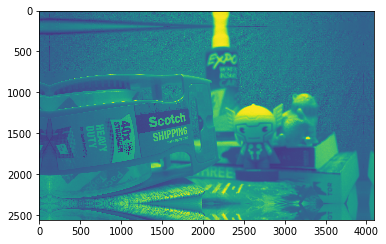

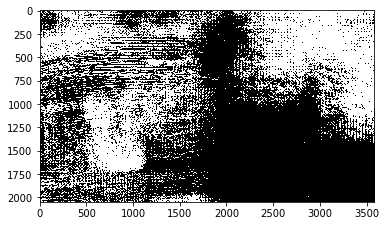

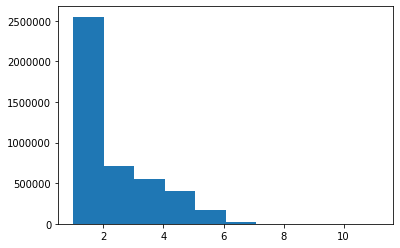

In [9]:
from skimage.color import rgb2gray
curr = 611
dist_map = None
dist_to_move = None
masks = []
gray_img = rgb2gray(c)
flag, dist_map, dist_to_move, masks = dist_est(gray_img, curr, dist_map, dist_to_move, masks)